Question 2

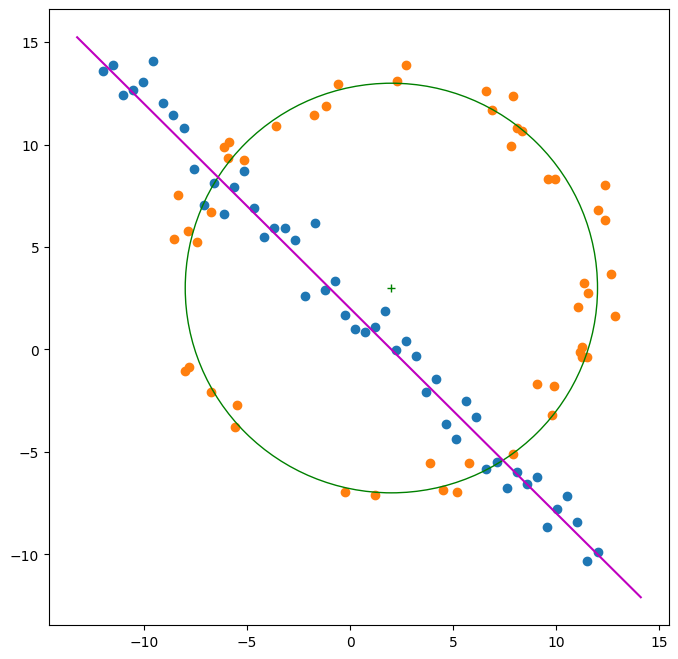

In [1]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np

# np.random.seed(0)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2,3 # center
s = r /16
# angle values in radian
t = np.random.uniform(0, 2*np.pi, half_n)
# noise values from 0 to s
n = s*np.random.randn(half_n)
# creating points on a noisy circle 
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))

s = 1
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
# creating points on a noisy line
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) #All points

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt) # add circle
ax.plot((x0_gt), (y0_gt), '+', color='g') # add centre of the circle
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

In [2]:
print(len(X))

100


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.718564360827054e-12
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
rex.x:  [0.74036856 0.67220116 1.08776828]
Iteration =  0 . No. inliners =  40
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.838620720016785
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.7235658  0.69025546 1.23347881] 6.838620720016785
A better model found ...  [0.7235658  0.69025546 1.23347881] 6.838620720016785
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2488597244714306e-08
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
rex.x:  [0.6710776  0.74138713 2.30249092]
Iteration =  1 . No. inliners =  25
Optimization terminated successfully    (Exit mode 0)
            Current functi

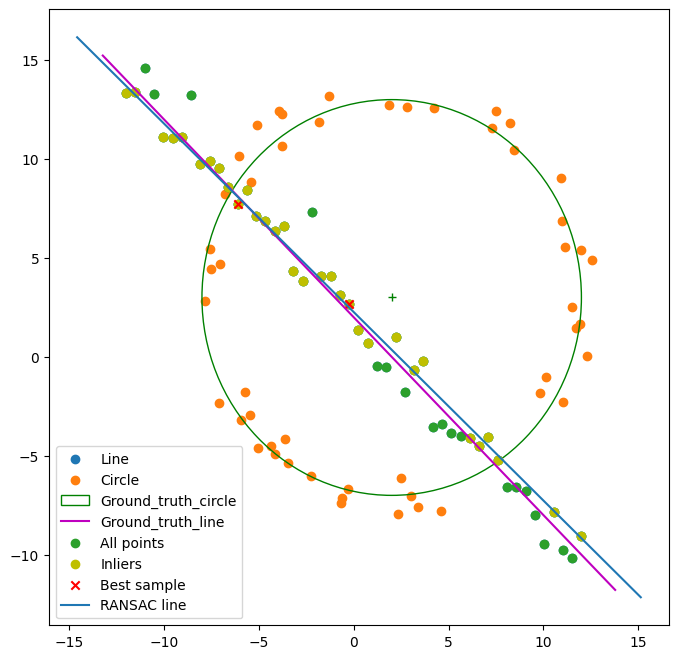

In [3]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np

# np.random.seed(0)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2,3 # center
s = r /16
# angle values in radian
t = np.random.uniform(0, 2*np.pi, half_n)
# noise values from 0 to s
n = s*np.random.randn(half_n)
# creating points on a noisy circle 
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))

s = 1
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
# creating points on a noisy line
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) #All points


# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
import math
from scipy.optimize import minimize
N = X_line.shape[0] # points
X_ = X_line

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
# returning the error
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))


# Constraint
# x = [a,b]
def g(x):
    return x[0]**2 + x[1]**2 - 1

# maintaining a**2 + b**2 = 1
cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t


t = 1.0   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 500
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of 2 points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate a,b,d

    #return many things but res.x contains a,b,d
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-7, constraints=cons, options={'disp': True})

    #returns indexes of cordinates of inliners
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers

    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum()) # number of inliners

    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        #return many things but res.x contains a,b,d
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})

        print(res.x, res.fun) # what is fun
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt) # add circle
ax.plot((x0_gt), (y0_gt), '+', color='g') # add centre of the circle
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], marker='x', color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[0]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
plt.legend()

In [4]:
new_xline = X_line[~best_inliers_line]
X = np.vstack((X_circ, new_xline)) #All points

X = np.vstack((X_circ, X_line)) #All points


# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
import math
import numpy as np
from scipy.optimize import minimize
N = X_line.shape[0] # points
X_ = X_line


def circle_tls(x, indices):
    x0, y0, r = x[0], x[1], x[2]
    return np.sum(np.square(X_[indices, 0] - x0) + np.square(X_[indices, 1] - y0) - r**2)


def consensus_circle(X_, x, t):
    xc, yc, r = x[0], x[1], x[2]
    error = np.absolute(np.square(X_[:,0]) + np.square(b*X_[:,1]) - r**2)
    return error < t

t = 1.0   # Threshold value to determine data points that are fit well by model.
d = 0.*N   # Number of close data points required to assert that a model fits well to data.
s = 3       # Minimum number of data points required to estimate model parameters.

cons_circle = ({'type': 'ineq', 'fun': lambda x: x[2] - t})

inliers_circle = []        # Indinces of the inliers
max_iterations = 500
iteration = 0
best_model_circle = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_circle = []    # Three-point sample leading to the best model computation
res_only_with_sample_circle = [] # Result (xc, yc, r) only using the best sample
best_inliers_circle = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of 3 points selected at random
    x0 = np.array([1, 1, 1]) # Initial estimate xc, yc, r

    #return many things but res.x contains a,b,d
    res = minimize(fun = circle_tls, args = indices, x0 = x0, tol= 1e-7, constraints=cons, options={'disp': True})

    #returns indexes of cordinates of inliners
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers

    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum()) # number of inliners

    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        #return many things but res.x contains a,b,d
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})

        print(res.x, res.fun) # what is fun
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1


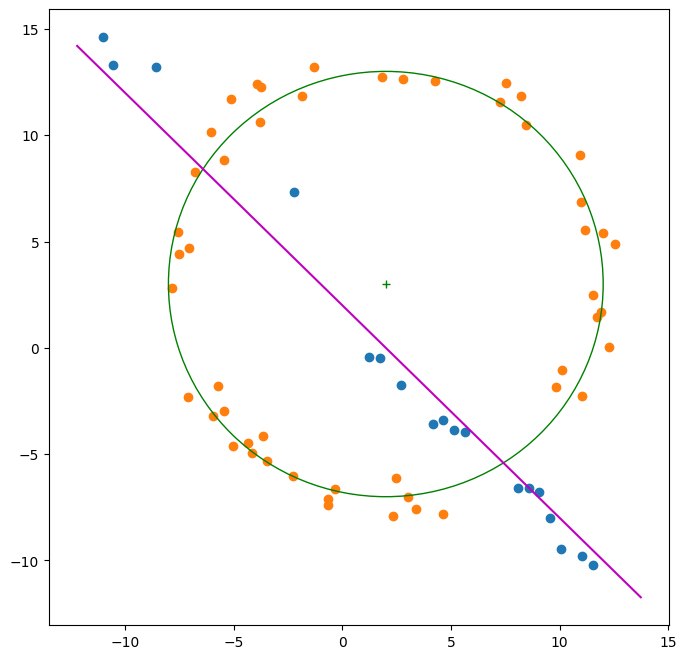

In [56]:
print(len(new_xline)+len(X_circ))
print(len(best_inliers_line))
# print(X_line)
# print(new_xline)

78
50


Question 3

In [ ]:
import numpy as np
import cv as cv

def click_event(event, x, y, flags, param):
    global corner_points

    # If the left mouse button is clicked, record the coordinates
    if event == cv.EVENT_LBUTTONDOWN:
        corner_points.append((x, y))
        cv.circle(background_image, (x, y), 5, (0, 0, 255), -1)  # Draw a red circle at the clicked point
        cv.imshow('Image',background_image)

        # If all four corners are selected, stop capturing clicks
        if len(corner_points) == 4:
            cv.destroyAllWindows()


corners = []

img=cv.cvtColor(cv.imread('images/collage1.png'), cv.COLOR_BGR2RGB)

background_image = cv.imread('Screenshot 2023-09-30 205348.png')
#background_image_orig = cv.cvtColor(cv.imread('Screenshot 2023-09-30 185402.png'), cv.COLOR_BGR2RGB)
# Display the image and set a mouse callback function
cv.imshow('Image', background_image)
cv.setMouseCallback('Image', click_event)

# Wait for user interaction
cv.waitKey(0)

# Print the selected corner points
print("Selected Corner Points:")
for point in corner_points:
    print(point)

# Load the background image (architectural image)

In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

clicked_coordinates = []
click_count = 0

# Mouse callback function
def mouse_callback(event, x, y, flags, param):
    global clicked_coordinates, click_count

    # If left mouse button is clicked, capture the coordinates and draw a marker
    if event == cv.EVENT_LBUTTONDOWN:
        clicked_coordinates.append((x, y))
        click_count += 1
        cv.circle(image, (x, y), 5, (0, 0, 255), -1)  # Draw a red circle as a marker
        cv.imshow("Image", image)

        # If four clicks are captured, stop capturing
        if click_count == 4:
            cv.destroyAllWindows()


image = cv.imread("images/collage1.png") 
cv.imshow("Image", image)

cv.setMouseCallback("Image", mouse_callback)

cv.waitKey(0)

# Output the coordinates
print("Clicked Coordinates:")
for i, (x, y) in enumerate(clicked_coordinates, start=1):
    print(f"Point {i}: ({x}, {y})")

# Optionally, display the image with markers in Matplotlib
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image_rgb)
for (x, y) in clicked_coordinates:
    plt.plot(x, y, 'ro')  # Draw a red marker
plt.show()


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
